In [1]:
import numpy as np


import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

import torch.nn.functional as F

import pandas as pd

from matplotlib import pyplot as plt

%matplotlib inline

from livelossplot import PlotLosses

Using TensorFlow backend.


In [2]:
planes=np.load("/home/user/data/airplane.npy")
onions=np.load("/home/user/data/onion.npy")
apples=np.load("/home/user/data/apple.npy")
pineapples=np.load("/home/user/data/pineapple.npy")
ants=np.load("/home/user/data/ant.npy")
bananas=np.load("/home/user/data/banana.npy")
ambulances=np.load("/home/user/data/ambulance.npy")
angels=np.load("/home/user/data/angel.npy")

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 8)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    train_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        train_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        train_correct += pred.eq(target.view_as(pred)).sum().item()
    
    avg_loss = train_loss / len(train_loader.dataset)
    avg_accuracy = train_correct / len(train_loader.dataset)
    

        
   # print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
   #             epoch, batch_idx * len(data), len(train_loader.dataset),
   #             100. * batch_idx / len(train_loader), loss.item()))
    
    return avg_loss, avg_accuracy


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(target.view_as(pred)).sum().item()
    

    test_loss /= len(test_loader.dataset)
    avg_loss_val = test_loss
    avg_accuracy_val = test_correct / len(test_loader.dataset)

    
        

   # print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    #    test_loss, test_correct, len(test_loader.dataset),
    #    100. * test_correct / len(test_loader.dataset)))
    
    return avg_loss_val, avg_accuracy_val



In [5]:
#Tworzenie danych do testów, tak samo jak do trenowania
# .reshape(-1, 1, 28, 28) pierwszy wymiar sam się przelicza tak, żeby pasowac do rozmiaru wyjściowej tablicy
pltest = planes[1::200].reshape(-1, 1, 28, 28).astype('float32')
ontest = onions[1::200].reshape(-1, 1, 28, 28).astype('float32')
aptest = apples[1::200].reshape(-1, 1, 28, 28).astype('float32')
pinetest = pineapples[1::200].reshape(-1, 1, 28, 28).astype('float32')
antest = ants[1::200].reshape(-1, 1, 28, 28).astype('float32')
batest = bananas[1::200].reshape(-1, 1, 28, 28).astype('float32')
amtest = ambulances[1::200].reshape(-1, 1, 28, 28).astype('float32')
angtest = angels[1::200].reshape(-1, 1, 28, 28).astype('float32')


pltest /= 255
ontest /= 255
aptest /= 255
pinetest /= 255
antest /= 255
batest /= 255
amtest /= 255
angtest /=255

pltest_t = torch.from_numpy(pltest)
ontest_t = torch.from_numpy(ontest)
aptest_t = torch.from_numpy(aptest)
pinetest_t = torch.from_numpy(pinetest)
antest_t = torch.from_numpy(antest)
batest_t = torch.from_numpy(batest)
amtest_t = torch.from_numpy(amtest)
angtest_t = torch.from_numpy(angtest)

X_test = torch.cat((pltest_t, ontest_t, aptest_t, pinetest_t, antest_t, batest_t, amtest_t, angtest_t), 0)
Y_test = torch.LongTensor(pltest_t.size(0)*[0]+ontest_t.size(0)*[1]+aptest_t.size(0)*[2]+pinetest_t.size(0)*[3]+antest_t.size(0)*[4]+batest_t.size(0)*[5]+amtest_t.size(0)*[6]+angtest_t.size(0)*[7])

In [6]:
pltrain = planes[::200].reshape(-1, 1, 28, 28).astype('float32')
ontrain = onions[::200].reshape(-1, 1, 28, 28).astype('float32')
aptrain = apples[::200].reshape(-1, 1, 28, 28).astype('float32')
pinetrain = pineapples[::200].reshape(-1, 1, 28, 28).astype('float32')
antrain = ants[::200].reshape(-1, 1, 28, 28).astype('float32')
batrain = bananas[::200].reshape(-1, 1, 28, 28).astype('float32')
amtrain = ambulances[::200].reshape(-1, 1, 28, 28).astype('float32')
angtrain = angels[::200].reshape(-1, 1, 28, 28).astype('float32')


pltrain /= 255
ontrain /= 255
aptrain /= 255
pinetrain /= 255
antrain /= 255
batrain /= 255
amtrain /= 255
angtrain /=255

pltrain_t = torch.from_numpy(pltrain)
ontrain_t = torch.from_numpy(ontrain)
aptrain_t = torch.from_numpy(aptrain)
pinetrain_t = torch.from_numpy(pinetrain)
antrain_t = torch.from_numpy(antrain)
batrain_t = torch.from_numpy(batrain)
amtrain_t = torch.from_numpy(amtrain)
angtrain_t = torch.from_numpy(angtrain)

X_train = torch.cat((pltrain_t, ontrain_t, aptrain_t, pinetrain_t, antrain_t, batrain_t, amtrain_t, angtrain_t), 0)
Y_train = torch.LongTensor(pltrain_t.size(0)*[0]+ontrain_t.size(0)*[1]+aptrain_t.size(0)*[2]+pinetrain_t.size(0)*[3]+antrain_t.size(0)*[4]+batrain_t.size(0)*[5]+amtrain_t.size(0)*[6]+angtrain_t.size(0)*[7])

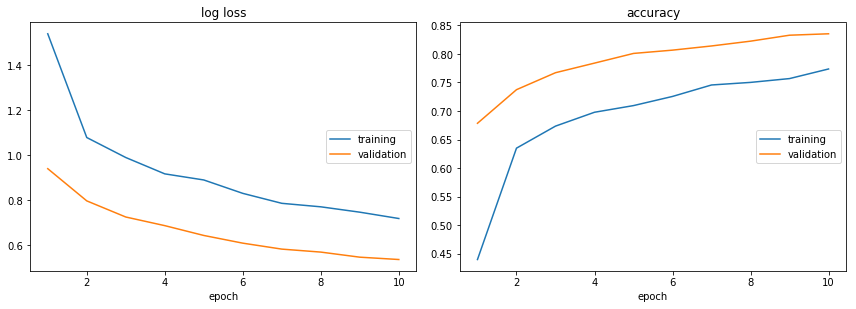

In [7]:
model = Net()
device = torch.device("cpu")
        
train_loader  = DataLoader(TensorDataset(X_train,Y_train),
                         batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test),
                         batch_size=32, shuffle=False)  
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

liveloss = PlotLosses()

for epoch in range(10):

    avg_loss, avg_accuracy = train(model, device, train_loader, optimizer, epoch)  
    avg_loss_val, avg_accuracy_val = test(model, device, test_loader)
    
    liveloss.update({
        'val_log loss': avg_loss_val,
        'val_accuracy': avg_accuracy_val,
        'log loss': avg_loss,
        'accuracy': avg_accuracy,
    })
    
    liveloss.draw()




In [8]:
Accuracy_test = 100. * avg_accuracy_val
Accuracy_test

83.51750972762646

In [9]:
Log_loss_test = avg_loss_val
Log_loss_test

0.5359770500984637

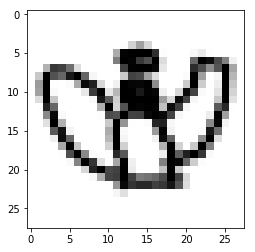

In [10]:
plt.imshow(X_test[-1].reshape(28, 28), cmap='Greys')

In [11]:
#Wyciągamy tę pierwszą warstwę
kernels = model.conv1.weight.detach().cpu().numpy()

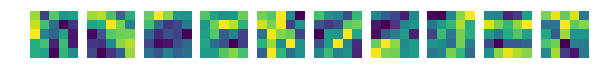

In [12]:
column = 10
rows = np.int(kernels.shape[0]/column)
fig, axs = plt.subplots(rows, column, figsize=(column, rows))
j = 0
axs = axs.reshape(rows, column)
for i in range(rows):
    for k in range(column):
        ax = axs[i, k]
        ax.imshow(kernels[j,0])
        #plt.colorbar()
        ax.axis('off')
        j = j+1




#plt.imshow(kernels[3,0])

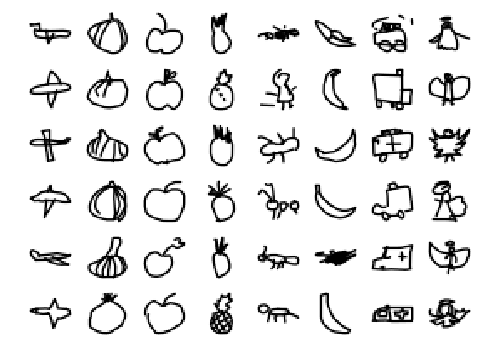

In [13]:
#Losowe obrazki z danej kategorii
rows = 6
class_num = 8
fig, axs = plt.subplots(rows, class_num, figsize=(class_num, rows))
for class_id in range(class_num):
    classes = X_train[Y_train == class_id]
    for i in range(rows):
        ax = axs[i, class_id]
        ax.imshow(classes[np.random.randint(len(classes)),0].reshape(28,28),
                  cmap='Greys', interpolation='none')
        ax.axis('off')


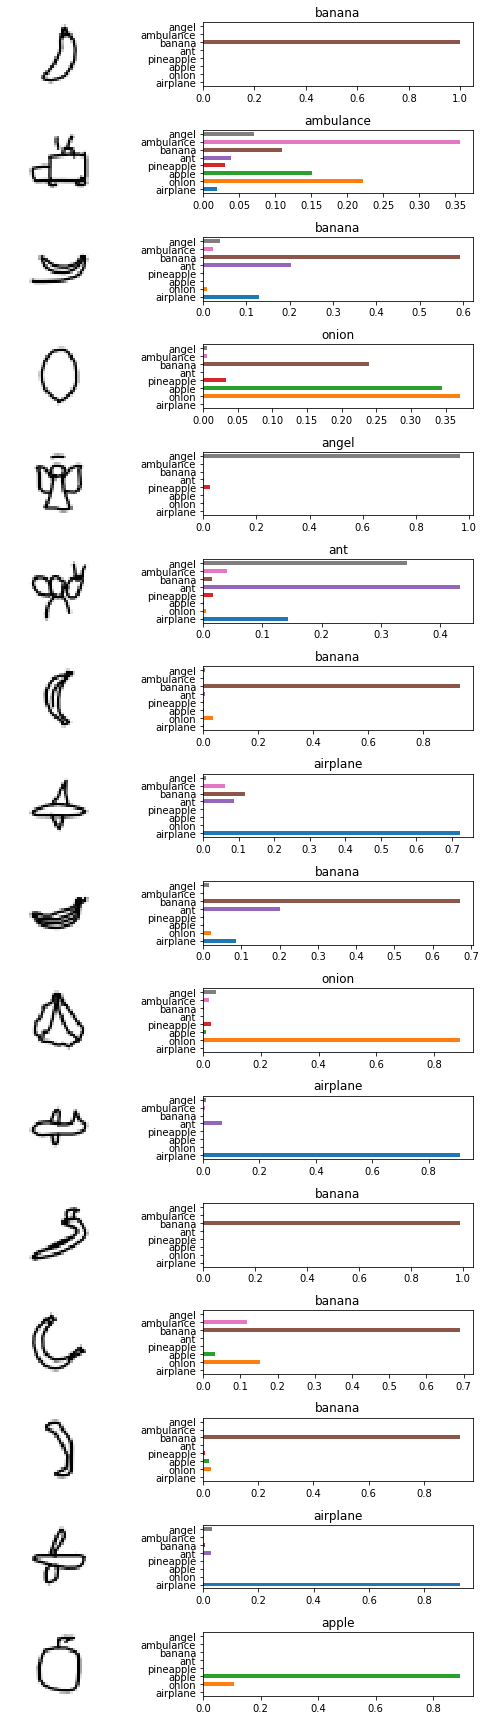

In [14]:
# random example predictions
#predictions = model.predict(X_test)
#predictions = F.softmax(model(X_test), dim = 1)

class_names = ['airplane', 'onion', 'apple', 'pineapple', 'ant', 'banana', 'ambulance', 'angel']
rows = 16
fig, axs = plt.subplots(rows, 2, figsize=(8, 1.5 * rows))
for i in range(rows):
    ax = axs[i,0]
    idx = np.random.randint(len(X_test))
    ax.imshow(X_test[idx,0].reshape(28,28),
              cmap='Greys', interpolation='none')
    ax.axis('off')
        
    pd.Series(F.softmax(model(X_test[idx].unsqueeze(0)), dim = 1).detach().numpy()[0], index=class_names).plot('barh', ax=axs[i,1], ylim=[0,1], title=class_names[Y_test[idx]])

plt.tight_layout()


#, index=list("01")

In [15]:
res = model(X_test).max(dim=1)[1]
eq = (Y_test != res)

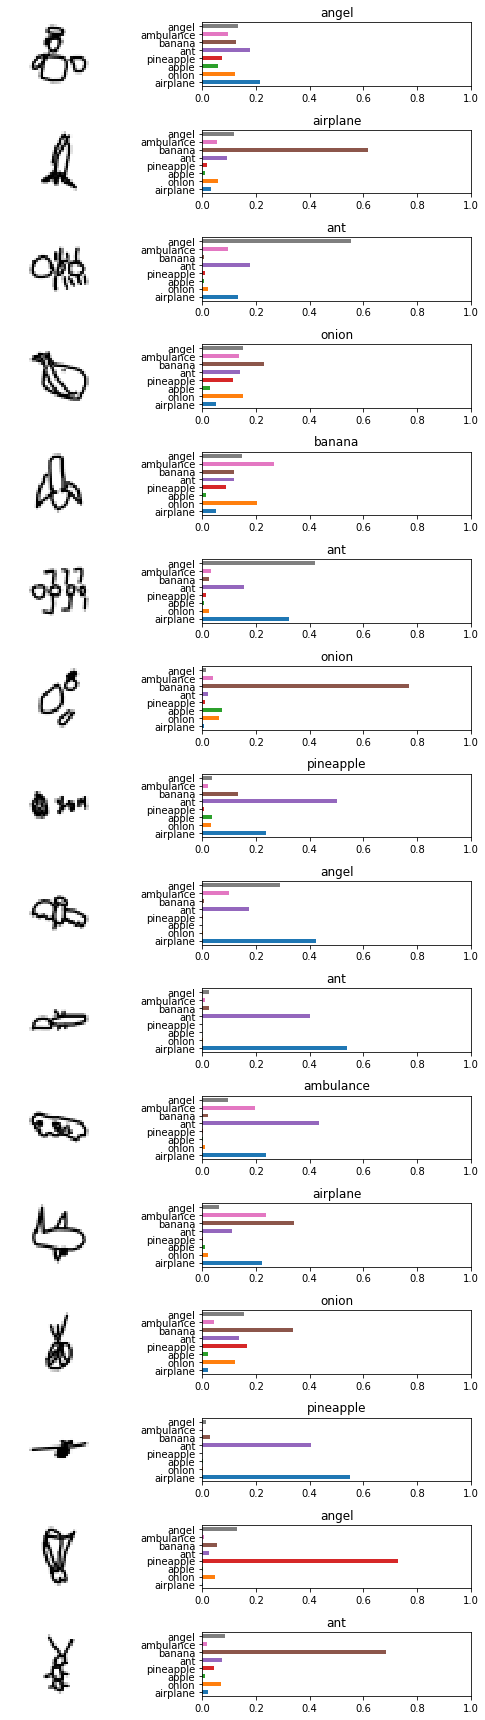

In [16]:
# example predictions
#predictions = model.predict(X_test)

good = Y_test[eq]
class_names = ['airplane', 'onion', 'apple', 'pineapple', 'ant', 'banana', 'ambulance', 'angel']
test_fail = X_test[eq] #Tylko złe wyniki
predictions = F.softmax(model(test_fail), dim = 1)

rows = 16
fig, axs = plt.subplots(rows, 2, figsize=(8, 1.5 * rows))
for i in range(rows):
    ax = axs[i,0]
    idx = np.random.randint(len(test_fail))
    
    ax.imshow(test_fail[idx,0].reshape(28,28),
              cmap='Greys', interpolation='none')
    
    ax.axis('off')
        
    pd.Series(predictions[idx].detach().numpy(), index=class_names).plot('barh', ax=axs[i,1], xlim=[0,1], title=class_names[good[idx]])
    
    
plt.tight_layout()


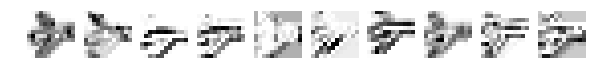

In [17]:
#Rysuje wszystkie kanały po przejściu pierwszej warstwy
Conv_l = F.relu(F.max_pool2d(model.conv1(X_train), 2))

rows1 = 1
columns1 = Conv_l.shape[1]
fig, axs = plt.subplots(rows1, columns1, figsize=(columns1, rows1))
axs = axs.reshape(rows1, columns1)
for kernel_id in range(columns1):
    #letters = Conv_l[Y_train == class_id]
    for i in range(rows1):
        ax = axs[i, kernel_id]
        ax.imshow(Conv_l[i,kernel_id].reshape(12,12).detach().numpy(),
                  cmap='Greys', interpolation='none')
        ax.axis('off')
        


In [18]:
Conv_l2 = F.relu(F.max_pool2d(model.conv2_drop(model.conv2(Conv_l)), 2))

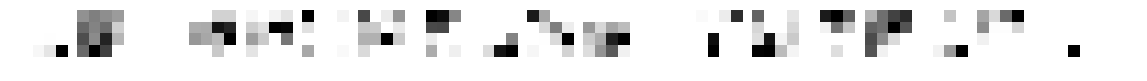

In [19]:
#Rysuje wszystkie kanały po przejściu pierwszej i drugiej warstwy
rows = 1
columns = Conv_l2.shape[1]
fig, axs = plt.subplots(rows, columns, figsize=(columns, rows))
axs = axs.reshape(rows,columns)
for kernel_id in range(columns):
    #letters = Conv_l[Y_train == class_id]
    for i in range(rows):
        ax = axs[i, kernel_id]
        ax.imshow(Conv_l2[i,kernel_id].reshape(4,4).detach().numpy(),
                  cmap='Greys', interpolation='none')
        ax.axis('off')

Rysunek numer 5006 :


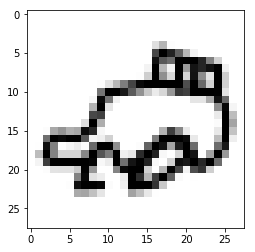

Pierwsza warstwa:


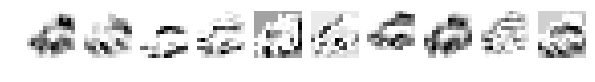

Druga warstwa:


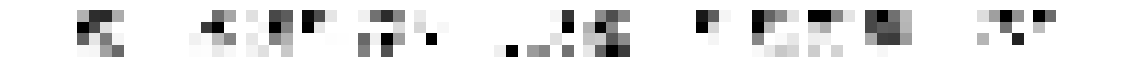

In [20]:
#Rysunek losowy
id_rys = np.random.randint(len(X_train))
print("Rysunek numer", id_rys,":")
plt.imshow(X_train[id_rys].reshape(28, 28), cmap='Greys')
plt.show()

#Rysuje wszystkie kanały po przejściu pierwszej warstwy
print("Pierwsza warstwa:")
rows_r = 2
columns_r = Conv_l.shape[1]
fig, axs = plt.subplots(rows1, columns1, figsize=(columns1, rows1))
axs = axs.reshape(rows1, columns1)
for kernel_id in range(columns1):
    #letters = Conv_l[Y_train == class_id]
    for i in range(rows1):
        ax = axs[i, kernel_id]
        ax.imshow(Conv_l[id_rys,kernel_id].reshape(12,12).detach().numpy(),
                  cmap='Greys', interpolation='none')
        ax.axis('off')
        
plt.show()
        
#Rysuje wszystkie kanały po przejściu pierwszej i drugiej warstwy
print("Druga warstwa:")
rows = 1
columns = Conv_l2.shape[1]
fig, axs = plt.subplots(rows, columns, figsize=(columns, rows))
axs = axs.reshape(rows,columns)

for kernel_id in range(columns):
    #letters = Conv_l[Y_train == class_id]
    for i in range(rows):
        ax = axs[i, kernel_id]
        ax.imshow(Conv_l2[id_rys,kernel_id].reshape(4,4).detach().numpy(),
                  cmap='Greys', interpolation='none')
        ax.axis('off')

In [23]:
conf_m = torch.tensor(np.array(64*[0]).reshape(8,8), dtype=torch.int32)
p = 0
class_num = 8
iterator = torch.tensor([pltest_t.size(0), ontest_t.size(0), aptest_t.size(0), pinetest_t.size(0),
                         antest_t.size(0), batest_t.size(0), amtest_t.size(0), angtest_t.size(0)])
for k in range(class_num):
    for j in range(class_num):
        conf_m[k][j] = 0
        for i in range(iterator[k]):
            if (res[p + i] == j):
                conf_m[k][j] += 1
    p += iterator[k]


In [24]:
conf_m

tensor([[ 582,    2,    0,    0,  117,   13,   13,   32],
        [   9,  419,   97,   35,   19,   47,   17,   19],
        [   2,    3,  692,    6,    3,   10,    5,    3],
        [   3,   15,   23,  542,    7,   14,    3,   19],
        [  65,    3,    2,    3,  471,   48,   10,   22],
        [  14,    7,   11,    8,   28, 1458,    9,    5],
        [  14,    9,   16,    1,   32,   12,  639,   18],
        [  70,   15,    3,   33,   30,   12,   23,  563]], dtype=torch.int32)

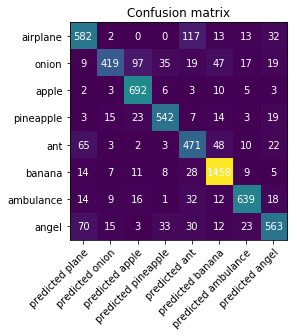

In [25]:
class_names = ['airplane', 'onion', 'apple', 'pineapple', 'ant', 'banana', 'ambulance', 'angel']
predictions = ["predicted plane", "predicted onion", "predicted apple", "predicted pineapple", 'predicted ant',
               'predicted banana', 'predicted ambulance', 'predicted angel']

fig, ax = plt.subplots()
im = ax.imshow(conf_m)

# Labels place
ax.set_xticks(np.arange(len(predictions)))
ax.set_yticks(np.arange(len(class_names)))
# Labels
ax.set_xticklabels(predictions)
ax.set_yticklabels(class_names)

# Rotation and alignment of the labels
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(class_names)):
    for j in range(len(predictions)):
        text = ax.text(j, i, conf_m[i][j].item(), #taking a value out of the tensor
                       ha="center", va="center", color="w")

ax.set_title("Confusion matrix")
#fig.tight_layout() #Making the image smaller
plt.show()